In [ ]:
# ============================================================
# 📦 Step 1: Upload Dataset ZIP
# ============================================================

from google.colab import files
import zipfile, os

print("📤 Please upload your dataset ZIP file (e.g., data.zip)")
uploaded = files.upload()

# Extract the first uploaded file
for filename in uploaded.keys():
    zip_path = f"/content/{filename}"
    print(f"📁 Unzipping {filename} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/data")
print("✅ Extraction complete!")

# Check directory structure
!ls /content/data


📤 Please upload your dataset ZIP file (e.g., data.zip)


Saving archive (1).zip to archive (1).zip
📁 Unzipping archive (1).zip ...
✅ Extraction complete!
data


In [ ]:
# ✅ Check extracted folder structure
import os

for root, dirs, files in os.walk("/content/data"):
    level = root.replace("/content/data", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:3]:  # limit output
        print(f"{subindent}{f}")


data/
  data/
    validation/
      Onychogryphosis/
        Screen-Shot-2021-11-16-at-10-39-52-PM_png.rf.516df24e53038f9f31e2bca0af74ff48.jpg
        Screen-Shot-2021-11-16-at-10-23-59-PM_png.rf.ba787af7af07499d7f481c020332ac2a.jpg
        Screen-Shot-2021-11-16-at-10-24-09-PM_png.rf.864ca33e07c8aca34ad661182541cce1.jpg
      Healthy_Nail/
        h23_png.rf.c7c509ee51e926570eef01670971a12d.jpg
        h42_png.rf.16c0757e4e7efb45784ff84d76fbc941.jpg
        h28_png.rf.703767728e747d391e99c44cf7f8eb55.jpg
      blue_finger/
        Screen-Shot-2021-10-15-at-10-41-24-AM_png.rf.79aabe37924d244e8c96e49f030e57bf.jpg
        Screen-Shot-2021-10-15-at-10-44-09-AM_png.rf.fa5059ea7a03fc7853fa574ce5b05a59.jpg
        Screen-Shot-2021-10-15-at-10-43-29-AM_png.rf.5ad468e58cd936dc0d5306b02e2c5be6.jpg
      clubbing/
        Screen-Shot-2021-10-26-at-12-09-28-PM_png.rf.1b2bfb63b6e848f2cb0257c23a2a356b.jpg
        Screen-Shot-2021-10-26-at-12-07-03-PM_png.rf.2a2d2f13976b58b491b4eda7ae861da6.jpg
    

In [ ]:
# ============================================================
# 🔹 Step 1: Import Libraries
# ============================================================
import os
import zipfile
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================
# 🔹 Step 2: Setup Device
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ============================================================
# 🔹 Step 3: Dataset Paths
# ============================================================
data_dir = "/content/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

assert os.path.exists(train_dir), f"❌ Train folder not found: {train_dir}"
assert os.path.exists(val_dir), f"❌ Validation folder not found: {val_dir}"

# ============================================================
# 🔹 Step 4: Data Augmentation & Normalization
# ============================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ============================================================
# 🔹 Step 5: Load Datasets
# ============================================================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"📊 Detected {num_classes} classes: {class_names}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# ============================================================
# 🔹 Step 6: Load Pretrained EfficientNet
# ============================================================
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Replace final layer
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

# ============================================================
# 🔹 Step 7: Define Loss, Optimizer, and Scheduler
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# ============================================================
# 🔹 Step 8: Training Loop
# ============================================================
num_epochs = 25
best_val_acc = 0.0

train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    print(f"\n🚀 Epoch [{epoch+1}/{num_epochs}]")
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / total
    train_acc_history.append(train_acc)

    # 🔹 Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_acc = correct / total
    val_loss = val_loss / total
    val_acc_history.append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # 🔹 Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_model.pth")
        print("✅ Best model saved.")

# ============================================================
# 🔹 Step 9: Evaluation
# ============================================================
model.load_state_dict(torch.load("best_efficientnet_model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n📈 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
print("✅ Overall Accuracy:", accuracy_score(all_labels, all_preds))

# ============================================================
# 🔹 Step 10: Confusion Matrix
# ============================================================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================================================
# 🔹 Step 11: Accuracy Curve
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


✅ Using device: cuda


AssertionError: ❌ Train folder not found: /content/data/train

In [ ]:
import os

for root, dirs, files in os.walk("/content/data"):
    level = root.replace("/content/data", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")


data/
  data/
    validation/
      Onychogryphosis/
      Healthy_Nail/
      blue_finger/
      clubbing/
      pitting/
      Acral_Lentiginous_Melanoma/
    train/
      Onychogryphosis/
      Healthy_Nail/
      blue_finger/
      clubbing/
      pitting/
      Acral_Lentiginous_Melanoma/


In [ ]:
train_dir = "/content/data/data/train"
val_dir = "/content/data/data/validation"


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Using device: cuda
📂 Classes found: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 127MB/s] 



🚀 Starting training...

Epoch [1/25] Train Loss: 1.6399 | Train Acc: 35.66% | Val Loss: 1.5231 | Val Acc: 52.75%
Epoch [2/25] Train Loss: 1.4256 | Train Acc: 53.90% | Val Loss: 1.3327 | Val Acc: 64.84%
Epoch [3/25] Train Loss: 1.2753 | Train Acc: 60.68% | Val Loss: 1.1993 | Val Acc: 71.43%
Epoch [4/25] Train Loss: 1.1624 | Train Acc: 64.42% | Val Loss: 1.0990 | Val Acc: 71.43%
Epoch [5/25] Train Loss: 1.0937 | Train Acc: 66.43% | Val Loss: 1.0246 | Val Acc: 74.73%
Epoch [6/25] Train Loss: 1.0286 | Train Acc: 68.51% | Val Loss: 0.9732 | Val Acc: 75.82%
Epoch [7/25] Train Loss: 0.9766 | Train Acc: 69.82% | Val Loss: 0.9307 | Val Acc: 74.73%
Epoch [8/25] Train Loss: 0.9516 | Train Acc: 69.12% | Val Loss: 0.8885 | Val Acc: 74.73%
Epoch [9/25] Train Loss: 0.9267 | Train Acc: 70.09% | Val Loss: 0.8799 | Val Acc: 73.63%
Epoch [10/25] Train Loss: 0.9093 | Train Acc: 71.05% | Val Loss: 0.8743 | Val Acc: 73.63%
Epoch [11/25] Train Loss: 0.8957 | Train Acc: 70.83% | Val Loss: 0.8585 | Val Acc: 7

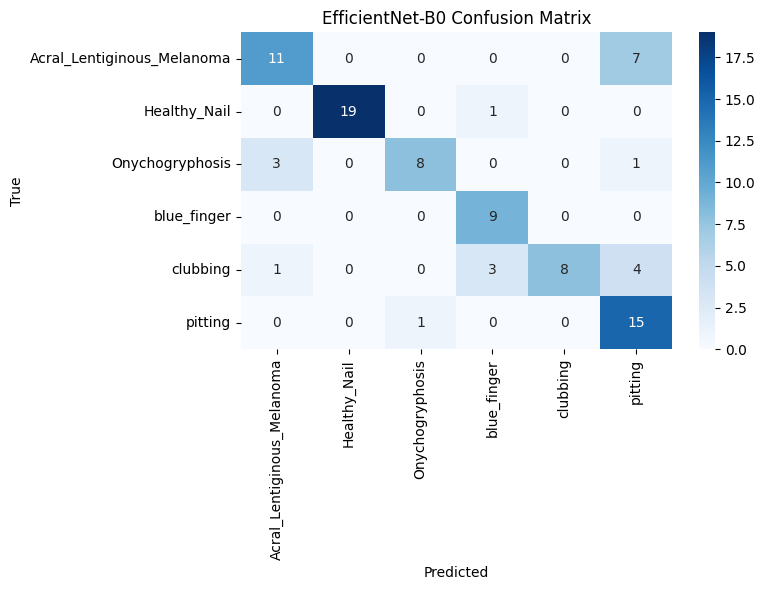

In [ ]:
# ============================================================
# 📦 EfficientNetB0 Training for Nail Disease Classification
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================
# ⚙️ Configuration
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

data_dir = "/content/data/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")

assert os.path.exists(train_dir), f"❌ Train folder not found: {train_dir}"
assert os.path.exists(val_dir), f"❌ Validation folder not found: {val_dir}"

num_classes = 6
batch_size = 32
num_epochs = 25
learning_rate = 1e-4

# ============================================================
# 🔄 Data Augmentation
# ============================================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ============================================================
# 📚 Load Datasets
# ============================================================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("📂 Classes found:", class_names)

# ============================================================
# 🧠 Load Pretrained EfficientNet
# ============================================================
model = models.efficientnet_b0(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# ============================================================
# ⚙️ Loss and Optimizer
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

# ============================================================
# 🚀 Training Loop
# ============================================================
best_val_acc = 0.0
train_losses, val_losses = [], []

print("\n🚀 Starting training...\n")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss / len(val_loader))

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_model.pth")

print(f"\n✅ Training complete! Best Validation Accuracy: {best_val_acc:.2f}%")

# ============================================================
# 📊 Evaluation on Validation Set
# ============================================================
model.load_state_dict(torch.load("best_efficientnet_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("EfficientNet-B0 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()  # upload your zip file again


Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile, os

zip_path = list(uploaded.keys())[0]  # automatically get uploaded file name
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted folders inside /content/data:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")



✅ Extracted folders inside /content/data:
data/
  data/
    validation/
      Onychogryphosis/
      Healthy_Nail/
      blue_finger/
      clubbing/
      pitting/
      Acral_Lentiginous_Melanoma/
    train/
      Onychogryphosis/
      Healthy_Nail/
      blue_finger/
      clubbing/
      pitting/
      Acral_Lentiginous_Melanoma/


✅ Using device: cuda
📎 Please upload your dataset ZIP file (e.g., archive.zip)


Saving archive (1).zip to archive (1) (1).zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Extraction complete!
📁 Train dir: /content/data/data/train
📁 Validation dir: /content/data/data/validation
📃 Classes: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']
📸 Train: 3744, Validation: 91
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]



📅 Epoch 1/25
--------------------------------------------------
Train Loss: 1.1686 | Train Acc: 0.5887
Val Loss:   0.7859 | Val Acc:   0.7692

📅 Epoch 2/25
--------------------------------------------------
Train Loss: 0.8121 | Train Acc: 0.7188
Val Loss:   0.6775 | Val Acc:   0.8132

📅 Epoch 3/25
--------------------------------------------------
Train Loss: 0.7450 | Train Acc: 0.7342
Val Loss:   0.6293 | Val Acc:   0.7912

📅 Epoch 4/25
--------------------------------------------------
Train Loss: 0.6818 | Train Acc: 0.7567
Val Loss:   0.6110 | Val Acc:   0.8242

📅 Epoch 5/25
--------------------------------------------------
Train Loss: 0.6658 | Train Acc: 0.7577
Val Loss:   0.5915 | Val Acc:   0.8352

📅 Epoch 6/25
--------------------------------------------------
Train Loss: 0.6467 | Train Acc: 0.7610
Val Loss:   0.5957 | Val Acc:   0.8242

📅 Epoch 7/25
--------------------------------------------------
Train Loss: 0.6166 | Train Acc: 0.7746
Val Loss:   0.5761 | Val Acc:   0.8242

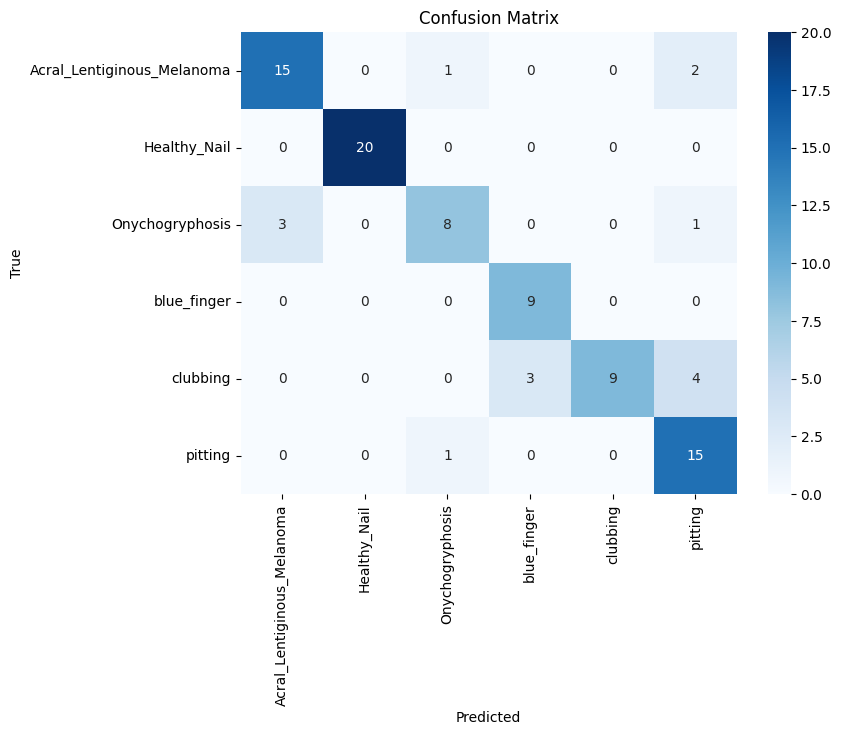

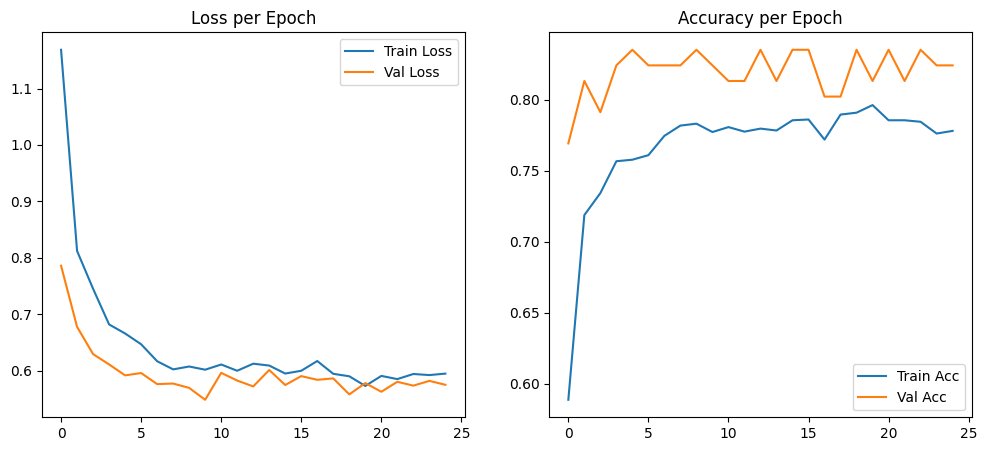

In [ ]:
# ============================================================
# ┨ Step 1: Imports
# ============================================================
import os
import zipfile
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import torch.nn.functional as F

# ============================================================
# ⚙️ Step 2: Setup Device and Dataset
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# --- Upload ZIP ---
from google.colab import files
print("📎 Please upload your dataset ZIP file (e.g., archive.zip)")
uploaded = files.upload()

zip_name = list(uploaded.keys())[0]
extract_path = "/content/data"

# --- Extract ZIP ---
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Extraction complete!")

# --- Find Correct Train/Val Paths Automatically ---
def find_train_val(root_path):
    train_path, val_path = None, None
    for root, dirs, files in os.walk(root_path):
        if "train" in dirs and "validation" in dirs:
            train_path = os.path.join(root, "train")
            val_path = os.path.join(root, "validation")
            break
    return train_path, val_path

train_dir, val_dir = find_train_val(extract_path)
assert train_dir and val_dir, "❌ Couldn't find train/validation folders automatically!"
print(f"📁 Train dir: {train_dir}\n📁 Validation dir: {val_dir}")

# ============================================================
# 🧠 Step 3: Data Transforms
# ============================================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ============================================================
# 📚 Step 4: Datasets & Loaders
# ============================================================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"📃 Classes: {class_names}")
print(f"📸 Train: {len(train_dataset)}, Validation: {len(val_dataset)}")

# ============================================================
# ┨ Step 5: Model Setup (EfficientNet)
# ============================================================
model = models.efficientnet_b0(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze base layers

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# ============================================================
# 🏃‍♂️ Step 6: Train Function
# ============================================================
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # --- Training ---
        model.train()
        running_loss, running_corrects = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # --- Validation ---
        model.eval()
        val_loss, val_corrects = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)

        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_effnet.pth")

        scheduler.step()

    print(f"\n✅ Best Validation Accuracy: {best_acc:.4f}")
    return model, history

# ============================================================
# 🚀 Step 7: Train
# ============================================================
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# ============================================================
# 📊 Step 8: Evaluation
# ============================================================
model.load_state_dict(torch.load("best_effnet.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n📈 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================================
# 📉 Step 9: Training Curves
# ============================================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy per Epoch")
plt.show()

# ============================================================
# 🔍 Step 10: Grad-CAM Visualization
# ============================================================
def grad_cam_visualization(model, img_path, class_names):
    model.to(device) # Ensure model is on the correct device
    model.eval()

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = val_transform
    input_tensor = transform(Image.fromarray(img)).unsqueeze(0).to(device)

    # Hook for features and gradients
    features, gradients = None, None

    def forward_hook(module, input, output):
        nonlocal features
        features = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    layer = model.features[-1]
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    # Forward + backward
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    model.zero_grad()
    output[0, pred_class].backward()

    # Grad-CAM computation
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * features).sum(dim=1).squeeze().cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam = cam / cam.max()

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM for: {class_names[pred_class]}")
    plt.axis("off")
    plt.show()

# Example usage (replace with any image path from validation folder)
# grad_cam_visualization(model, f"{val_dir}/Healthy_Nail/h23_png.rf.c7c509ee51e926570eef01670971a12d.jpg", class_names)


In [ ]:
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model saved successfully!")


NameError: name 'model' is not defined

In [ ]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))


<All keys matched successfully>

In [ ]:
# Check folder structure
!ls -la /content
!ls -la /content/data
!ls -la /content/data/data  # you said data/data exists
!ls -la /content/data/data/validation | head -n 30


total 162620
drwxr-xr-x 1 root root     4096 Nov 10 14:31  .
drwxr-xr-x 1 root root     4096 Nov 10 14:01  ..
-rw-r--r-- 1 root root 66882237 Nov 10 14:20 'archive (1) (1).zip'
-rw-r--r-- 1 root root 66882237 Nov 10 14:10 'archive (1).zip'
-rw-r--r-- 1 root root 16360807 Nov 10 14:21  best_effnet.pth
-rw-r--r-- 1 root root 16360441 Nov 10 14:31  best_model.pth
drwxr-xr-x 4 root root     4096 Nov  5 14:33  .config
drwxr-xr-x 3 root root     4096 Nov 10 14:15  data
drwxr-xr-x 1 root root     4096 Nov  5 14:33  sample_data
total 12
drwxr-xr-x 3 root root 4096 Nov 10 14:15 .
drwxr-xr-x 1 root root 4096 Nov 10 14:31 ..
drwxr-xr-x 4 root root 4096 Nov 10 14:15 data
total 16
drwxr-xr-x 4 root root 4096 Nov 10 14:15 .
drwxr-xr-x 3 root root 4096 Nov 10 14:15 ..
drwxr-xr-x 8 root root 4096 Nov 10 14:15 train
drwxr-xr-x 8 root root 4096 Nov 10 14:15 validation
total 32
drwxr-xr-x 8 root root 4096 Nov 10 14:15 .
drwxr-xr-x 4 root root 4096 Nov 10 14:15 ..
drwxr-xr-x 2 root root 4096 Nov 10 14:15 

In [ ]:
import os
data_dir = "/content/data/data"   # <- CORRECT path for your setup
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")

print("Train exists:", os.path.isdir(train_dir))
print("Val exists:  ", os.path.isdir(val_dir))
assert os.path.isdir(train_dir), f"Train folder missing: {train_dir}"
assert os.path.isdir(val_dir), f"Validation folder missing: {val_dir}"
print("✅ Data path OK")


Train exists: True
Val exists:   True
✅ Data path OK


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1) (2).zip


In [ ]:
!ls -lh /content | grep best_model.pth
